In [1]:
from Bio import PDB, AlignIO
from Bio.PDB.Structure import Structure
from Bio.PDB.Chain import Chain
from Bio.PDB.Model import Model

from glob import glob
from pathlib import Path

In [2]:
parser = PDB.MMCIFParser()
model_files = glob("utp-data/af3-split/*/fold_*_model_0.cif")
structures = {
    Path(f)
    .stem.lstrip("fold_")
    .rstrip("_model_0"): parser.get_structure(
        Path(f).stem.lstrip("fold_").rstrip("_model_0"), f
    )
    for f in model_files
}

In [3]:
all_aligns = AlignIO.read("ucyn-a_enriched/ucyn-a_enriched_cobalt_cleaned.fa", "fasta")
structure_ids = set(structures.keys())

c_term_start = 880
c_term_end = 1010

aligns = {}
for align in all_aligns:
    full_id = align.id
    _id = " ".join(align.description.split(" ")[1:]).replace("-", "_").lower()
    if _id not in structure_ids:
        continue
    align.id = _id
    align.description = ""
    aligns[_id] = align

In [4]:

c_term_structs = {}
for seqid, align in aligns.items():
    # translate the aligned c_term_start and c_term_end to unaligned residue indicies
    start_idx = len(align.seq[:c_term_start].replace("-", ""))
    struct = structures[seqid]
    c_term_residues = list(struct.get_residues())[start_idx:]
    new_structure = Structure(seqid + "_c_term")
    new_chain = Chain("A")
    new_model = Model(0)

    for residue in c_term_residues:
        new_chain.add(residue)

    new_model.add(new_chain)
    new_structure.add(new_model)
    c_term_structs[seqid] = new_structure

In [5]:
from Bio.PDB import Superimposer

rmsd_results = {}
c_term_structs_list = list(c_term_structs.items())

for idx1, (seqid1, structure1) in enumerate(c_term_structs_list):
    for seqid2, structure2 in c_term_structs_list[idx1 + 1:]:
        if seqid1 != seqid2:
            atoms1 = list(structure1.get_atoms())
            atoms2 = list(structure2.get_atoms())
            if len(atoms1) > len(atoms2):
                atoms1 = atoms1[:len(atoms2)]
            elif len(atoms2) > len(atoms1):
                atoms2 = atoms2[:len(atoms1)]
            superimposer = Superimposer()
            superimposer.set_atoms(
                atoms1,
                atoms2,
            )
            rmsd = superimposer.rms
            rmsd_results[(seqid1, seqid2)] = rmsd

In [9]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Convert the RMSD results dictionary to a distance matrix
dist_matrix = np.zeros((len(rmsd_results), ))
for idx, rmsd in enumerate(rmsd_results.values()):
    dist_matrix[idx] = rmsd

In [15]:
len(dist_matrix), len(rmsd_results.keys())

(9453, 9453)

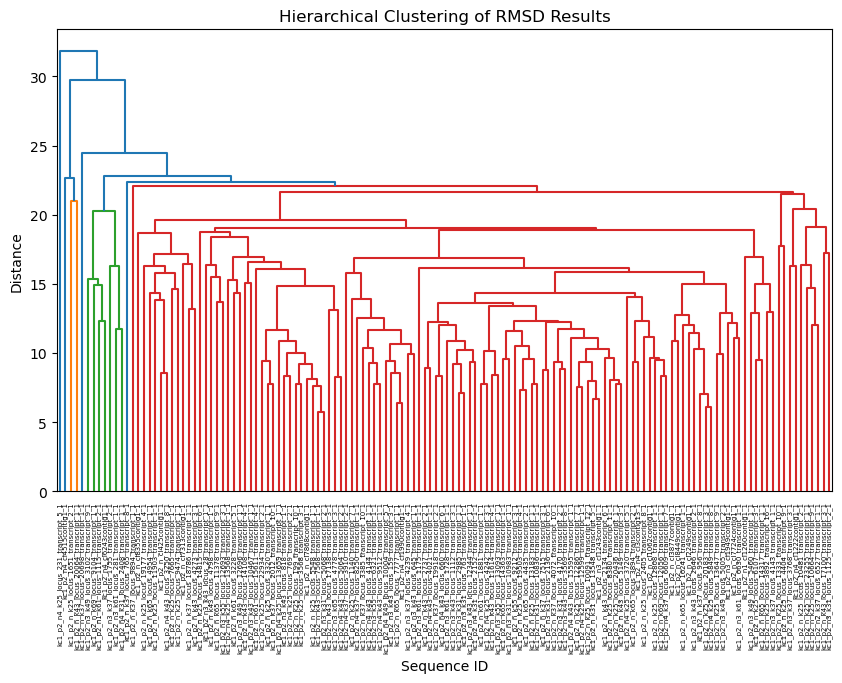

In [16]:
# Perform hierarchical clustering
Z = linkage(dist_matrix, method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=[s for s, _ in c_term_structs_list], leaf_rotation=90)
plt.xlabel('Sequence ID')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering of RMSD Results')
plt.show()